In [1]:
from glob import glob
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
%load_ext tensorboard

In [2]:
dataset_path = 'Dataset'
target_image = (124,124)
batch_size = 10
class_mode = 'categorical'

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'Dataset/train',
        target_size=target_image,
        batch_size=batch_size,
    shuffle=True,
        class_mode=class_mode)
validation_generator = test_datagen.flow_from_directory(
        'Dataset/validation',
        target_size=target_image,
    shuffle=False,
        batch_size=batch_size,
        class_mode=class_mode)

Found 17591 images belonging to 2 classes.
Found 13659 images belonging to 2 classes.


In [5]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'CT': 0, 'XRAY': 1}
{'CT': 0, 'XRAY': 1}


In [5]:
model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    input_shape=(124,124,3),
    include_top=False
)

x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(4,activation='relu')(x)
predictions = tf.keras.layers.Dense(2,activation='softmax')(x)
model_final = tf.keras.Model(inputs=model.input,outputs=predictions)

model_final.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 124, 124, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 61, 61, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 61, 61, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 61, 61, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
model_final.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [6]:
from datetime import datetime
EPOCHS = 200
checkpoint_filepath = './checkpoint_with_early_stopping'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    mode='min',
    save_best_only=True,
    save_freq='epoch'
)
model_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=4,
    verbose=1
)
model_tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
)

In [8]:
hist = model_final.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data = validation_generator,
    steps_per_epoch= train_generator.samples//train_generator.batch_size,
    validation_steps= validation_generator.samples//validation_generator.batch_size,
    callbacks=[model_tensorboard_callback,model_checkpoint_callback,model_early_stopping_callback],
    verbose=1)

Epoch 1/200
   1/1759 [..............................] - ETA: 0s - loss: 0.6650 - accuracy: 0.7000WARNING:tensorflow:From C:\Users\user\anaconda3\envs\ankit\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1759/1759 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8580
Epoch 00001: val_loss improved from inf to 0.18761, saving model to .\checkpoint_with_early_stopping
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\checkpoint_with_early_stopping\assets
1759/1759 [==============================] - 991s 564ms/step - loss: 0.3954 - accuracy: 0.8580 - val_loss: 0.1876

In [9]:
model_final.save('medical_image_classification_model2.h5')

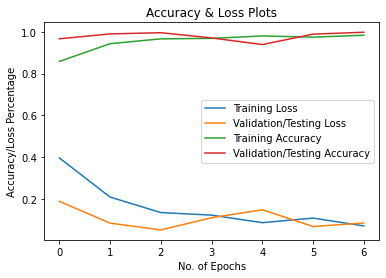

In [10]:
# Plotting model loss  accuracy without tight layout

plt.title('Accuracy & Loss Plots')
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation/Testing Loss')
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation/Testing Accuracy')
plt.legend()
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy/Loss Percentage')
plt.show()

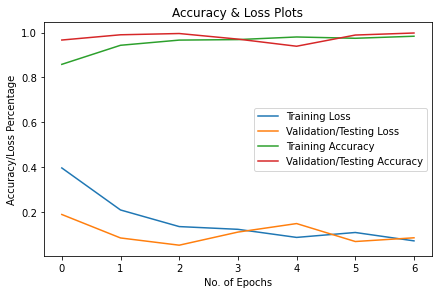

In [11]:
# Plotting model loss  accuracy with tight layout

plt.title('Accuracy & Loss Plots')
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation/Testing Loss')
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation/Testing Accuracy')
plt.legend()
plt.tight_layout()
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy/Loss Percentage')
plt.show()

In [12]:
err,acc = model_final.evaluate_generator(
    generator=validation_generator,
    steps=validation_generator.samples//validation_generator.batch_size,
    verbose=1
)
print(err,acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
1365/1365 [==============================] - 175s 128ms/step - loss: 0.0835 - accuracy: 0.9979
0.08350265026092529 0.997875452041626


In [7]:
mymodel = tf.keras.models.load_model(checkpoint_filepath)

In [8]:
validation_generator.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
# model performance analysis
# predicting on the validation images
val_predictions = mymodel.predict(validation_generator)
print(len(val_predictions))
# getting the max probabilites among the predicted one
max_pred_val = np.argmax(val_predictions,axis=1)
print(validation_generator.classes[:10],max_pred_val[:10])

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, max_pred_val))

print('Classification Report')
target_names = ['CT Images', 'X RAY Images']
print(classification_report(validation_generator.classes, max_pred_val, target_names=target_names))

13659
[0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
Confusion Matrix
[[6860    2]
 [  58 6739]]
Classification Report
              precision    recall  f1-score   support

   CT Images       0.99      1.00      1.00      6862
X RAY Images       1.00      0.99      1.00      6797

    accuracy                           1.00     13659
   macro avg       1.00      1.00      1.00     13659
weighted avg       1.00      1.00      1.00     13659



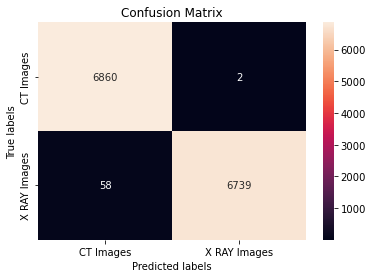

In [11]:
import seaborn as sns
mat = confusion_matrix(validation_generator.classes, max_pred_val)
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CT Images', 'X RAY Images']); ax.yaxis.set_ticklabels(['CT Images', 'X RAY Images']);

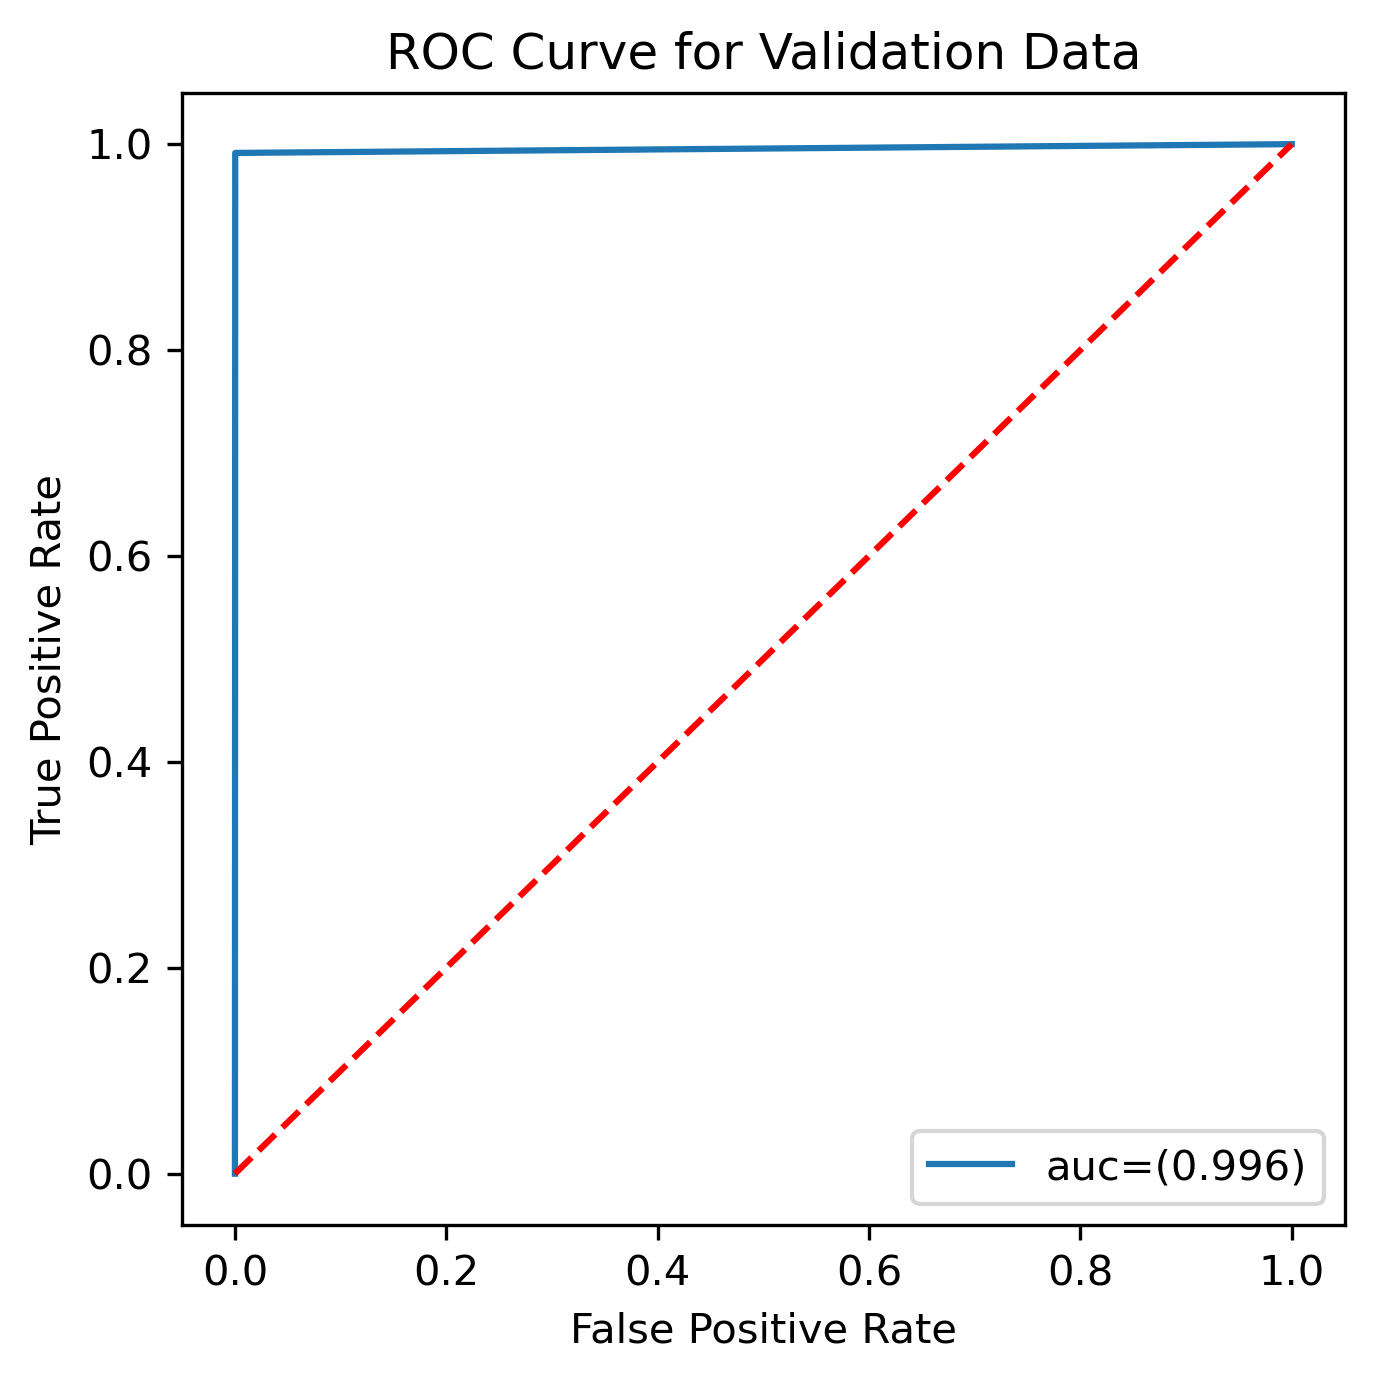

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(validation_generator.classes,max_pred_val)
auc_val = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=300)
plt.plot(fpr,tpr, linestyle='-', label='auc=(%0.3f)' % auc_val )
plt.plot([0,1],[0,1],'r--')
plt.title('ROC Curve for Validation Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


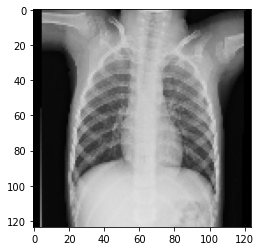

In [26]:
img = tf.keras.preprocessing.image.load_img('Dataset/train/XRAY/x nve (100).jpeg',target_size=target_image)
plt.imshow(img)
plt.show()

In [33]:
img_arr = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_arr,axis=0)

In [34]:
pred = mymodel.predict(img_batch/255)

In [35]:
pred

array([[3.9252045e-04, 9.9960750e-01]], dtype=float32)

In [36]:
max_pred = np.argmax(pred)
max_pred

1

In [38]:
validation_generator.class_indices

{'CT': 0, 'XRAY': 1}

In [2]:
mymodel = tf.keras.models.load_model('checkpoint_with_early_stopping')

In [3]:
mymodel.save('./base_medical_model.h5')